Final Project Part-B

Teammates: 
1. P Venkata Vaishnavi
2. Sohith Somasani

Performance Analysis Across Techniques:

Random Forest generalization:
  Mean MSE: 1.9175784832350649
  Median MSE: 1.8953087126623371
  Variance: 0.15350098247770075
  IQR: 0.5231108002435152

Random Forest memorization:
  Mean MSE: 0.2511586731459281
  Median MSE: 0.25280378883550503
  Variance: 0.00033772692600617327
  IQR: 0.02300949731677565

SGD Regressor generalization:
  Mean MSE: 1.3018783898110307e+29
  Median MSE: 8.160374347387804e+28
  Variance: 1.6296265759580576e+58
  IQR: 2.0122655048570455e+29

SGD Regressor memorization:
  Mean MSE: 1.2968121438407314e+29
  Median MSE: 8.155583431518186e+28
  Variance: 1.6146326653552165e+58
  IQR: 2.01189021219461e+29

Gradient Boosting generalization:
  Mean MSE: 1.917600980331997
  Median MSE: 1.9157932599263665
  Variance: 0.17241598727450472
  IQR: 0.5921888325572877

Gradient Boosting memorization:
  Mean MSE: 0.8800995674526735
  Median MSE: 0.8755069788788632
  Variance: 0.002650769002101691
  IQR: 0.07445804907245568

Linear 

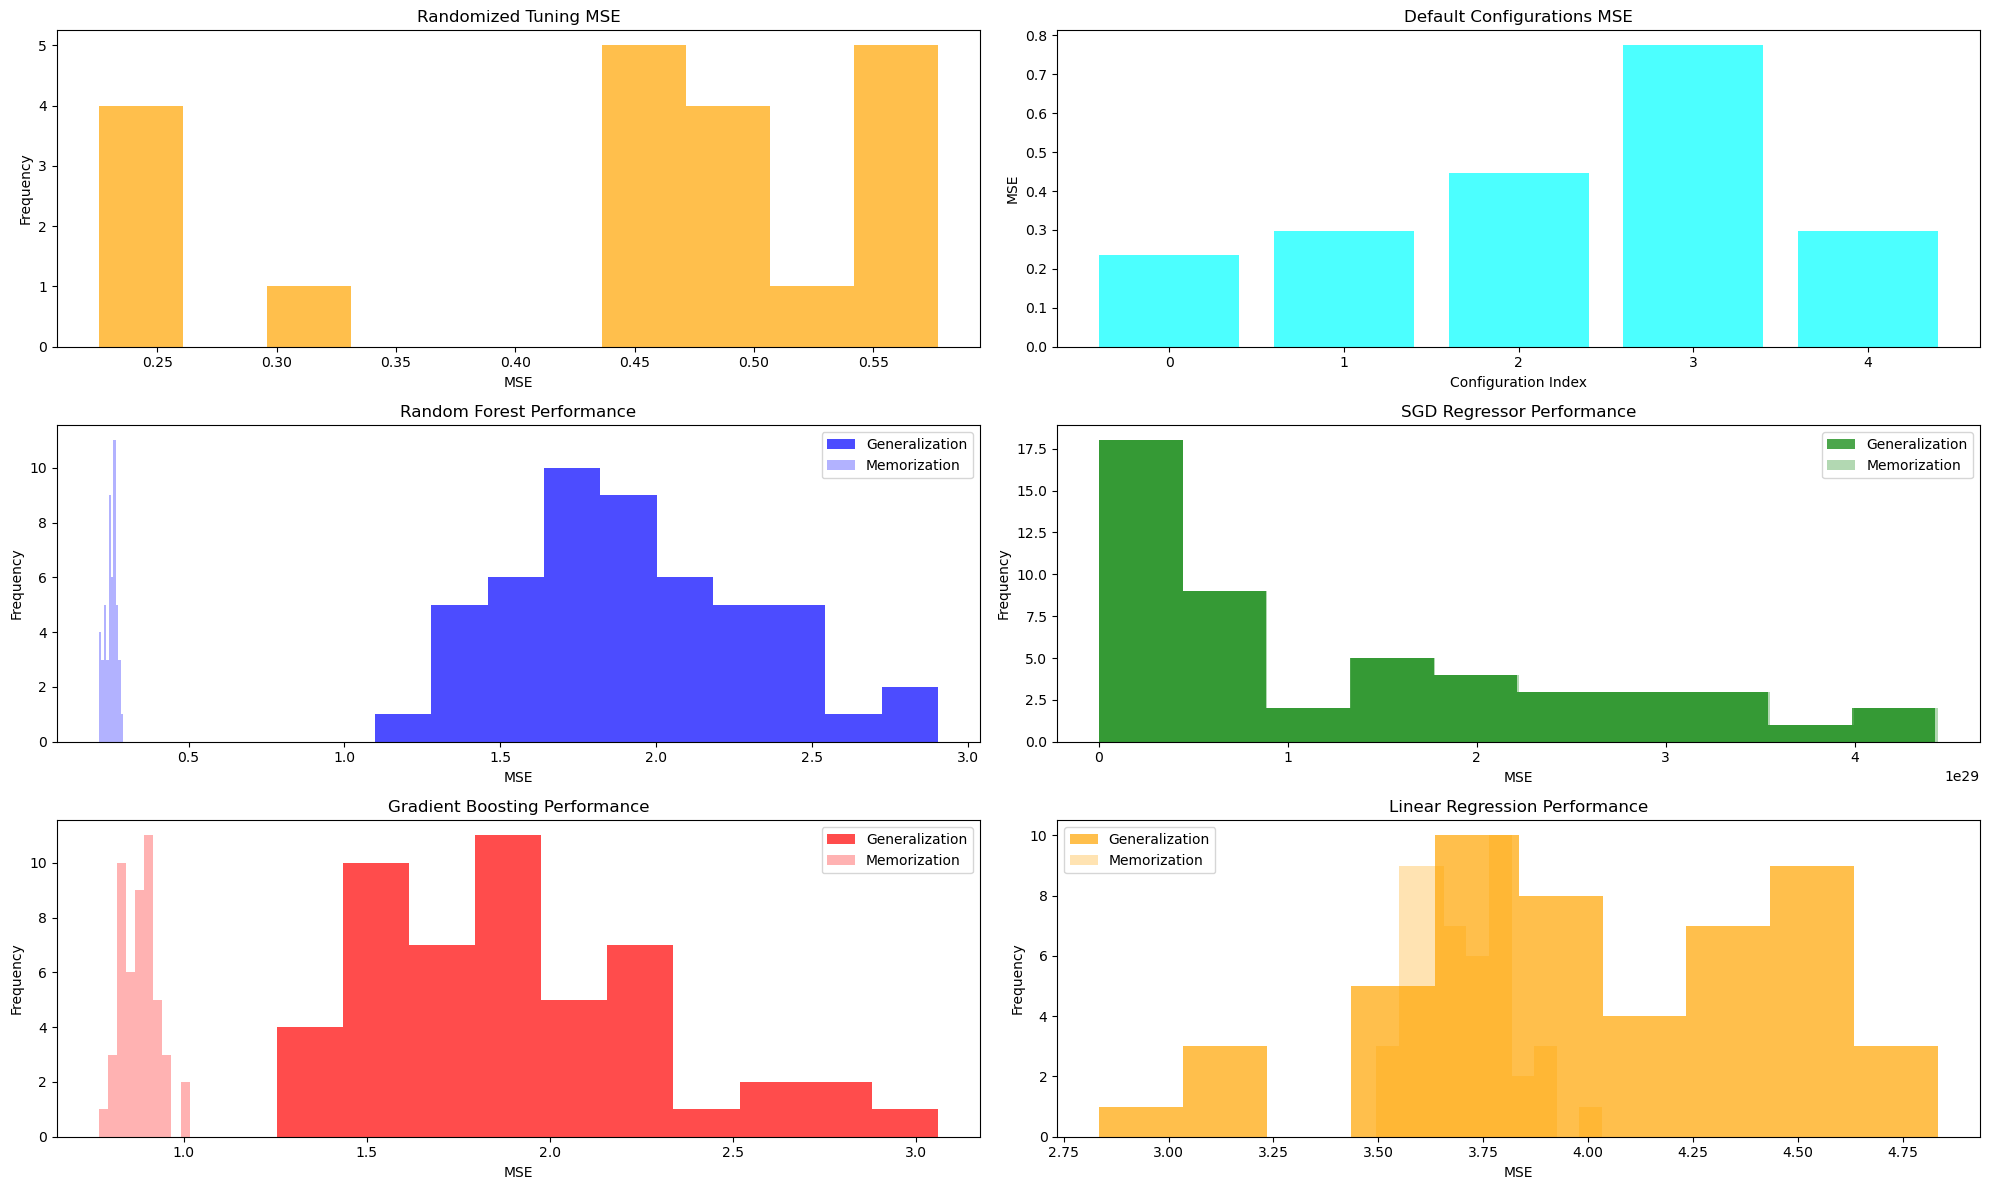

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel('ENB2012_data 2.xlsx')

# Assuming the target variable is the last column, and features are all others
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Add a new feature: Interaction term between two features
X['Feature_Interaction'] = X.iloc[:, 0] * X.iloc[:, 1]

# Parameters
test_size = 0.2
n_splits_list = [5, 10]  # Fold counts for K-Fold CV
n_iterations = 50
random_states = np.random.randint(0, 1000, n_iterations)

# Random Splits Analysis
mse_list_random_splits = []
for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=state)
    threshold = np.random.uniform(0.8, 1.2) * X_train.mean()
    X_train_filtered = X_train[(X_train < threshold).all(axis=1)]
    y_train_filtered = y_train.loc[X_train_filtered.index] if not X_train_filtered.empty else y_train
    X_train_filtered = X_train_filtered if not X_train_filtered.empty else X_train
    
    selector = SelectKBest(score_func=f_regression, k='all')
    X_train_selected = selector.fit_transform(X_train_filtered, y_train_filtered)
    X_test_selected = selector.transform(X_test)
    
    model = RandomForestRegressor(random_state=state)
    model.fit(X_train_selected, y_train_filtered)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    mse_list_random_splits.append(mse)

# Variability Analysis for Random Splits
mean_mse_splits = np.mean(mse_list_random_splits)
variance_mse_splits = np.var(mse_list_random_splits)
iqr_mse_splits = np.percentile(mse_list_random_splits, 75) - np.percentile(mse_list_random_splits, 25)

# K-Fold Cross-Validation Analysis
results_kfold = []
for n_splits in n_splits_list:
    mse_scores_kfold = []
    for state in random_states:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=state)
        model = RandomForestRegressor(random_state=state)
        mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
        scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
        mse_scores_kfold.append(-scores.mean())
    
    results_kfold.append({
        'n_splits': n_splits,
        'mean_mse': np.mean(mse_scores_kfold),
        'variance_mse': np.var(mse_scores_kfold),
        'iqr_mse': np.percentile(mse_scores_kfold, 75) - np.percentile(mse_scores_kfold, 25),
        'mse_scores': mse_scores_kfold
    })

# Random Initialization Analysis
mse_list_initialization = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
for state in random_states:
    model = RandomForestRegressor(random_state=state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_list_initialization.append(mse)

mean_mse_init = np.mean(mse_list_initialization)
variance_mse_init = np.var(mse_list_initialization)
iqr_mse_init = np.percentile(mse_list_initialization, 75) - np.percentile(mse_list_initialization, 25)

# Randomized Hyperparameter Tuning
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
mse_tuning = []
selected_params = []
for state in random_states[:20]:
    model = RandomForestRegressor(random_state=state)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=5,
        random_state=state,
        n_jobs=-1
    )
    random_search.fit(X, y)
    best_model = random_search.best_estimator_
    selected_params.append(random_search.best_params_)
    mse_tuning.append(mean_squared_error(y, best_model.predict(X)))

# Default Configurations
hyperparameter_variations = [
    {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2},
    {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5},
    {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 10},
    {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3}
]
mse_default = []
for config in hyperparameter_variations:
    model = RandomForestRegressor(**config, random_state=42)
    model.fit(X, y)
    mse_default.append(mean_squared_error(y, model.predict(X)))

# Comparison Across Techniques
results = {
    "Random Forest": {"generalization": [], "memorization": []},
    "SGD Regressor": {"generalization": [], "memorization": []},
    "Gradient Boosting": {"generalization": [], "memorization": []},
    "Linear Regression": {"generalization": [], "memorization": []},
}
for state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=state)
    models = {
        "Random Forest": RandomForestRegressor(random_state=state),
        "SGD Regressor": SGDRegressor(random_state=state, max_iter=1000, tol=1e-3),
        "Gradient Boosting": GradientBoostingRegressor(random_state=state),
        "Linear Regression": LinearRegression()
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
        results[name]["generalization"].append(mean_squared_error(y_test, model.predict(X_test)))
        results[name]["memorization"].append(mean_squared_error(y_train, model.predict(X_train)))

# Analysis
def analyze_results(results_dict):
    analysis = {}
    for technique, metrics in results_dict.items():
        for metric, mse_list in metrics.items():
            analysis[f"{technique} {metric}"] = {
                "Mean MSE": np.mean(mse_list),
                "Median MSE": np.median(mse_list),
                "Variance": np.var(mse_list),
                "IQR": np.percentile(mse_list, 75) - np.percentile(mse_list, 25)
            }
    return analysis

analysis = analyze_results(results)
print("Performance Analysis Across Techniques:")
for key, stats in analysis.items():
    print(f"\n{key}:")
    for metric, value in stats.items():
        print(f"  {metric}: {value}")

# Plotting
plt.figure(figsize=(20, 12))
plt.subplot(3, 2, 1)
plt.hist(mse_tuning, bins=10, color='orange', alpha=0.7)
plt.title('Randomized Tuning MSE')
plt.xlabel('MSE')
plt.ylabel('Frequency')

plt.subplot(3, 2, 2)
plt.bar(range(len(mse_default)), mse_default, color='cyan', alpha=0.7)
plt.title('Default Configurations MSE')
plt.xlabel('Configuration Index')
plt.ylabel('MSE')

colors = ['blue', 'green', 'red', 'orange']
for i, (technique, metrics) in enumerate(results.items()):
    plt.subplot(3, 2, i + 3)
    plt.hist(metrics["generalization"], bins=10, color=colors[i], alpha=0.7, label='Generalization')
    plt.hist(metrics["memorization"], bins=10, color=colors[i], alpha=0.3, label='Memorization')
    plt.title(f"{technique} Performance")
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


Lowest Uncertainty
Gradient Boosting exhibits the lowest uncertainty, with small variances (0.172 generalization, 0.00265 memorization) and narrow IQRs (0.592, 0.074), ensuring consistent and reliable performance across runs.

Highest Uncertainty
SGD Regressor shows the highest uncertainty, with extremely large variances (1.63 * 10^58 generalization, 1.61 * 10^58 memorization) and wide IQRs (2.01 * 10^29), indicating extreme instability.